In [2]:
!pip install gymnasium
!pip install pygame

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 3.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 6.7 MB/s eta 0:00:0000:0100:010m


# Carga y exploración de un entorno de Gymnasium

In [50]:
import gymnasium as gym
import numpy as np
import time
from IPython.display import clear_output, display, HTML
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import random
from itertools import product
from concurrent.futures import ProcessPoolExecutor, as_completed
import imageio
from IPython.display import HTML
import pickle

SEED = 42

# -------------------- VISUALIZACIÓN DE RESULTADOS --------------------

def graficar_recompensas(agente):
    """Grafica la recompensa media acumulada por episodio."""
    plt.figure(figsize=(6, 3))
    plt.plot(agente.stats)
    plt.title('Recompensa media acumulada')
    plt.xlabel('Episodio')
    plt.ylabel('Recompensa media')
    plt.grid(True)
    plt.show()

def graficar_longitud_episodios(agente):
    """Grafica la longitud de cada episodio."""
    plt.figure(figsize=(6, 3))
    plt.plot(agente.episode_lengths)
    plt.title("Longitud de episodios")
    plt.xlabel("Episodio")
    plt.ylabel("Pasos")
    plt.grid(True)
    plt.show()

def mostrar_resultados_agente_continuo(agente):
    """Muestra gráficos de rendimiento en entornos continuos."""
    graficar_recompensas(agente)
    graficar_longitud_episodios(agente)


# -------------------- EVALUACIÓN DE LA POLÍTICA --------------------

def evaluar_politica(agente, num_episodios=100):
    """Evalúa la política del agente ejecutando múltiples episodios y muestra estadísticas."""

    env = agente.env
    recompensas = []
    longitudes = []
    semillas_fallidas = []

    for i in range(num_episodios):
        random.seed(i)
        np.random.seed(i)
        env.action_space.seed(i)
        state, _ = env.reset(seed=i)
        done = False
        total_reward = 0
        posiciones = []
        pasos = 0

        terminated = False
        truncated = False
        
        while not done:
            posiciones.append(state[0])
            action = agente.seleccionar_accion_greedy(state)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            pasos += 1
            
            if truncated:
                semillas_fallidas.append(i)
                
        recompensas.append(total_reward)
        longitudes.append(pasos)
        env.close()

    # Resumen estadístico
    print("📊 Resultados de evaluación:")
    print(f"  Episodios evaluados: {num_episodios}")
    print(f"  Recompensa media:    {np.mean(recompensas):.2f} ± {np.std(recompensas):.2f}")
    print(f"  Recompensa min/max:  {np.max(recompensas):.2f} / {np.min(recompensas):.2f}")

    print(f"  Episodios exitosos:  {num_episodios - len(semillas_fallidas)}")
    print(f"  Episodios fallidos:  {len(semillas_fallidas)}")
    print(f"  Semillas fallidas: {semillas_fallidas}")



# Objeto AgenteSARSA-SemiGradiente (Fourier)

In [57]:
class AgenteSARSASemiGradienteFourier:
    def __init__(self, env, alpha=0.01, gamma=1.0, epsilon=1.0, decay=True, fourier_order=3):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.decay = decay
        self.fourier_order = fourier_order

        self.nA = env.action_space.n
        self.low = env.observation_space.low
        self.high = env.observation_space.high
        self.state_dim = env.observation_space.shape[0]

        # Generar los coeficientes c para Fourier basis
        self.c = np.array(list(product(range(fourier_order + 1), repeat=self.state_dim)))
        self.d = len(self.c)

        # Una theta por acción
        self.theta = np.zeros((self.nA, self.d))
        self.stats = []
        self.episode_lengths = []

    
    def guardar_agente(self, ruta_archivo="agente_sarsa_fourier.pkl"):
        """Guarda el agente SARSASemiGradienteFourier en un archivo pickle."""
        datos = {
            "alpha": self.alpha,
            "gamma": self.gamma,
            "epsilon": self.epsilon,
            "decay": self.decay,
            "fourier_order": self.fourier_order,
            "theta": self.theta,
            "stats": self.stats,
            "episode_lengths": self.episode_lengths,
            "c": self.c,
            "low": self.low,
            "high": self.high,
            "state_dim": self.state_dim,
            "nA": self.nA
        }
        with open(ruta_archivo, "wb") as f:
            pickle.dump(datos, f)
            
    @staticmethod
    def cargar_agente(ruta_archivo="agente_sarsa_fourier.pkl"):
        """Carga un agente SARSASemiGradienteFourier desde un archivo pickle."""
        with open(ruta_archivo, "rb") as f:
            datos = pickle.load(f)
    
        # Reconstruir el entorno
        env = gym.make("MountainCar-v0")
        env.reset(seed=SEED)
    
        agente = AgenteSARSASemiGradienteFourier(
            env,
            alpha=datos["alpha"],
            gamma=datos["gamma"],
            epsilon=datos["epsilon"],
            decay=datos["decay"],
            fourier_order=datos["fourier_order"]
        )
        
        # Restaurar parámetros
        agente.theta = datos["theta"]
        agente.stats = datos["stats"]
        agente.episode_lengths = datos["episode_lengths"]
        agente.c = datos["c"]
        agente.low = datos["low"]
        agente.high = datos["high"]
        agente.state_dim = datos["state_dim"]
        agente.nA = datos["nA"]
    
        return agente

    def _scale_state(self, state):
        """Escala el estado continuo al rango [0, 1]"""
        return (state - self.low) / (self.high - self.low)

    def _phi(self, state):
        """Devuelve vector de características Fourier para un estado escalado"""
        s_scaled = self._scale_state(state)
        return np.cos(np.pi * np.dot(self.c, s_scaled))

    def _Q(self, state, action):
        """Valor aproximado Q(s, a)"""
        return np.dot(self.theta[action], self._phi(state))

    # -------------------- POLÍTICAS Y SELECCIÓN DE ACCIONES --------------------

    def seleccionar_accion(self, state):
        """Selecciona una acción usando la política epsilon-soft explícita."""
        policy = self._epsilon_soft_policy_fourier(state)
        return np.random.choice(np.arange(self.nA), p=policy)

    def seleccionar_accion_greedy(self, state):
        """Selecciona una acción usando la política greedy."""
        q_values = [self._Q(state, a) for a in range(self.nA)]
        action = np.argmax(q_values)
        return action

    def _epsilon_soft_policy_fourier(self, state):
        """Devuelve una política epsilon-soft como vector de probabilidades."""
        q_values = np.array([self._Q(state, a) for a in range(self.nA)])
        policy = np.ones(self.nA) * self.epsilon / self.nA
        best_action = np.argmax(q_values)
        policy[best_action] += 1.0 - self.epsilon
        return policy


    def entrenar(self, num_episodes=5000, mostrar_barra=True):
        random.seed(SEED)
        np.random.seed(SEED)
    
        acumulador_recompensas = 0.0
    
        for t in tqdm(range(num_episodes), disable=not mostrar_barra):
            if self.decay:
                self.epsilon = min(1.0, 1000.0 / (t + 1))
    
            state, _ = self.env.reset()
            action = self.seleccionar_accion(state)
            done = False
            total_reward = 0
            pasos = 0
    
            while not done:
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                next_action = self.seleccionar_accion(next_state)
    
                phi = self._phi(state)
    
                if np.any(np.isnan(phi)) or np.any(np.isinf(phi)):
                    phi = np.nan_to_num(phi)
    
                q_current = self._Q(state, action)
                q_next = self._Q(next_state, next_action) if not done else 0.0
                target = reward + self.gamma * q_next
                delta = target - q_current
    
                if np.isnan(delta) or np.isinf(delta):
                    delta = 0.0  # ignorar la actualización problemática
    
                # Update con control de valores extremos
                self.theta[action] += self.alpha * delta * phi
                self.theta[action] = np.clip(self.theta[action], -1e3, 1e3)
    
                state = next_state
                action = next_action
                total_reward += reward
                pasos += 1
    
            self.episode_lengths.append(pasos)
            acumulador_recompensas += total_reward
            self.stats.append(acumulador_recompensas / (t + 1))
    
        return self.theta

In [11]:
def evaluar_configuracion(params, env_name="MountainCar-v0"):
    alpha, gamma, epsilon, fourier_order, decay = params
    env = gym.make(env_name)
    agente = AgenteSARSASemiGradienteFourier(
        env, alpha=alpha, gamma=gamma, epsilon=epsilon,
        decay=decay, fourier_order=fourier_order
    )
    agente.entrenar(num_episodes=5000, mostrar_barra=False)
    recompensa_final = np.mean(agente.stats[-100:])
    return (alpha, gamma, epsilon, fourier_order, decay, recompensa_final)

def random_search(env_name="MountainCar-v0", n_trials=100):
    # Espacio de búsqueda
    alphas = [0.01, 0.05, 0.1, 0.5]
    gammas = np.linspace(0.1, 1.0, 10)
    epsilons = np.linspace(0.1, 1.0, 10)
    fourier_orders = [1, 3, 5]

    combinaciones = []

    for _ in range(n_trials):
        a = random.choice(alphas)
        g = random.choice(gammas)
        f = random.choice(fourier_orders)
        decay = random.choice([True, False])
        if decay:
            e = 0.0  # ignorado
        else:
            e = random.choice(epsilons)
        combinaciones.append((a, g, e, f, decay))

    mejor_config = None
    mejor_recompensa = -float('inf')
    resultados = []

    print(f"🔍 Random Search: ejecutando {n_trials} configuraciones aleatorias...\n")

    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(evaluar_configuracion, combo, env_name) for combo in combinaciones]
        for future in tqdm(as_completed(futures), total=len(futures), desc="Progreso"):
            alpha, gamma, epsilon, fourier_order, decay_flag, recompensa = future.result()
            resultados.append((alpha, gamma, epsilon, fourier_order, decay_flag, recompensa))

            if recompensa > mejor_recompensa:
                mejor_recompensa = recompensa
                mejor_config = (alpha, gamma, epsilon, fourier_order, decay_flag)

    print("\n✅ Mejor configuración encontrada:")
    print(f" alpha = {mejor_config[0]}, γ = {mejor_config[1]}, ε = {mejor_config[2]}, "
          f"Fourier = {mejor_config[3]}, decay = {mejor_config[4]}")
    print(f"  → Recompensa media final: {mejor_recompensa:.4f}")


In [ ]:
random_search()

In [47]:
# Ejecución de ejemplo
env = gym.make("MountainCar-v0")
env.reset(seed=SEED)
agente = AgenteSARSASemiGradienteFourier(env, alpha=0.05, gamma=1.0, fourier_order=1, decay=True)
agente.entrenar(num_episodes=10000)

100%|█████████████████████████████████████████████████████████████████████████████| 10000/10000 [04:23<00:00, 37.92it/s]


array([[-84.11448941, -22.02776384,   5.81714768,  81.82645838],
       [-79.86354474, -41.18139544,   5.27656087,  92.84750049],
       [-80.53382211, -54.95998186,   5.36442613,  91.19607727]])

In [55]:
agente.guardar_agente()

In [51]:
agente = cargar_agente()

# Resultados de agente SARSA SemiGradiente (Fourier)

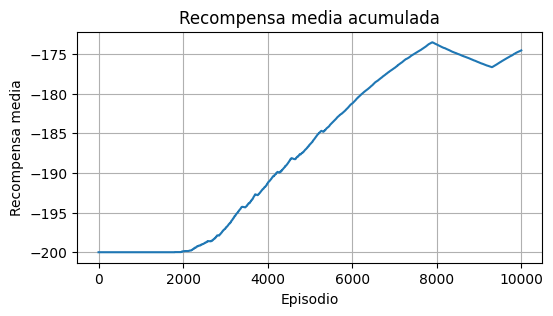

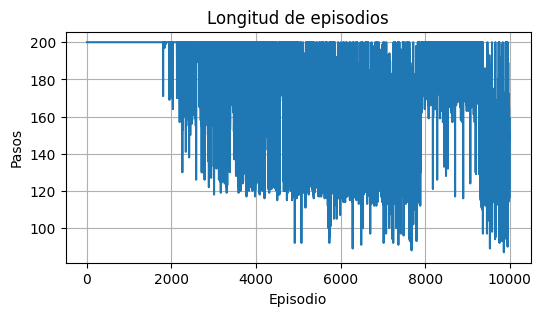

In [52]:
mostrar_resultados_agente_continuo(agente)

In [54]:
evaluar_politica(agente, num_episodios=100000)

📊 Resultados de evaluación:
  Episodios evaluados: 100000
  Recompensa media:    -138.62 ± 30.21
  Recompensa min/max:  -85.00 / -199.00
  Episodios exitosos:  100000
  Episodios fallidos:  0
  Semillas fallidas: []


In [ ]:
def grabar_video_agente(agente, seed, nombre_archivo="video_mountaincar.gif", fps=30):
    """
    Ejecuta un episodio con la política aprendida y guarda un video del entorno.
    """

    random.seed(seed)
    np.random.seed(seed)

    # Crear entorno con renderizado de imágenes
    env = gym.make("MountainCar-v0", render_mode="rgb_array")
    state, _ = env.reset(seed=seed)
    done = False
    total_reward = 0
    frames = []

    while not done:
        frame = env.render()
        frames.append(frame)

        action = agente.seleccionar_accion_greedy(state)
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward

        if done:
            break

    env.close()

    print(f"Número total de frames: {len(frames)}")
    # Guardar el video como GIF
    imageio.mimsave(nombre_archivo, frames, fps=fps, loop=0)
    print(f"🎥 Vídeo guardado en: {nombre_archivo}")
    print(f"🏁 Recompensa total obtenida: {total_reward:.2f}")

In [ ]:
nombre_archivo = "video_mountaincar_fourier.gif"

grabar_video_agente(agente, seed=98747, nombre_archivo=nombre_archivo)

HTML(f"""
<img src="{nombre_archivo}" style="width: 600px;" loop>
""")